In [ ]:
# system
import os
import sys
import time
import resource

from random import randint
from datetime import datetime

# io manipulation
import pandas as pd

# computation
import numpy as np
import math

# visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# machine learning
import cvxpy
from multiprocessing import Process, Pipe
from multiprocessing.pool import ThreadPool

import keras
from keras.datasets import mnist

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
## Preprocessing of data
# problem head
image_size = 784
num_classes = 10
num_worker = 10
max_iter = 15
lambda_ = 1
delta = 1
a_k = 0.005
a_k2 = 0.0005
a_k3 = 0.00005

# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], image_size).T
x_test = x_test.reshape(x_test.shape[0], image_size).T

x_train = x_train/255.0
x_test = x_test/255.0

# data split
def split_workers(X_data, y_data, num_worker):
    data_X_list=[]
    data_y_list=[]
    num_data = len(y_data)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[:,i:j]
        y_data_worker = y_data[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
        
    return data_X_list, data_y_list

workers_x, workers_y = split_workers(x_train, y_train, num_worker)

In Assignment 4, we use DGD (decentralized gradient descent) on a multi-class SVM:
\begin{equation} \nonumber
\begin{aligned}
    \text{min}_W\;& L = \underset{data\ loss}{\underbrace{\frac{1}{K}\sum_{i\in[K]}L_i}} + \underset{regularization\ loss}{\underbrace{\lambda \sum_{m\in[N]}R_m(W)}}\\
    \text{where}\;& L_i = \sum_{m\neq y_i} \text{max}(0, \langle w_{y_i}, x_i \rangle - \langle w_{m}, x_i \rangle  + \Delta) \\
    & R_m(W) = \frac{1}{2} \langle w_m, w_m \rangle
\end{aligned}
\end{equation}
where the data is split but $W$ shared among workers. The functions are defined as below for multiclass SVM and decentralized updation.

In [ ]:
# ------------------------- SVM Classificaton ----------------------------------

#multiclass SVM classification loss and its gradient
def SVM_classify(x, w):
    return np.argmax(np.matmul(x.T, w), axis = 1).reshape(x.shape[1], 1)

def SVM_cost(x, y, w):
    svm_cost = (np.matmul(x.T, w) - np.repeat(np.multiply(x.T, w[:,y.reshape(y.shape[0])].T).sum(axis = 1).reshape(y.shape[0], 1), 10, axis = 1) + delta).clip(min = 0)
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] = 0
    return svm_cost

def regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).sum() + lambda_/2 * np.linalg.norm(w)**2

def SVM_cost_grad(x, y, w, lambda_):
    svm_cost = SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad_coef = svm_cost
    svm_cost_grad_coef[(range(y.shape[0]), y.reshape(y.shape[0]))] -= svm_cost.sum(axis=1)
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_grad[:, i] = np.multiply(svm_cost_grad_coef[:, i].reshape(svm_cost_grad_coef.shape[0], 1), x.T).sum(axis = 0)
    return svm_cost_grad

#plot loss vs signaling at master node
def plot_master_loss(k):
    colors = iter(cm.rainbow(np.linspace(0, 1, len(curves[k]))))
    legends = []
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        T, loss = zip(*errs)
        plt.plot(T, loss, color = next(colors))
        legends.append(legend)
    plt.xlabel("Signaling (T)")
    plt.ylabel("Loss")
    #plt.yscale("log")
    plt.title('Convergence vs signaling (%s)' % k)
    if len(legends) > 1:
        plt.legend(legends)
    plt.show()

#plot greyscale plots of computed models of each digit
def plot_w_ks(w_k):
    fig, axarr = plt.subplots(nrows=2, ncols=5)
    for i in range(10):
        axarr[int(i / 5), int(i % 5)].imshow(w_k[:28*28,i].reshape(28, 28), cmap='gray', interpolation='none')
        axarr[int(i / 5), int(i % 5)].set_title("Digit: {}".format(i))
        axarr[int(i / 5), int(i % 5)].set_xticks([])
        axarr[int(i / 5), int(i % 5)].set_yticks([])
    plt.show()
    
#plot average agent loss vs signaling and the region between min and max loss
def plot_agents_loss(k):
    colors = iter(cm.rainbow(np.linspace(0, 10, len(curves[k].keys()))))
    legends = []
    for legend in curves[k].keys():
        w_k, errs = curves[k][legend]
        color = next(colors)
        T, losses = zip(*errs)
        legends.append(legend)
        losses = np.array(losses)
        mean = np.array(losses).mean(axis = 1)
        lmin = np.array(losses).min(axis = 1)
        lmax = np.array(losses).max(axis = 1)
        var = np.array(losses).var(axis = 1)
        plt.plot(np.array(T), mean, color = color)
    plt.fill_between(T, lmin, lmax,facecolor = color, alpha=0.2, edgecolor='none')
    plt.xlabel("Signaling (T)")
    plt.ylabel("Loss")
    #plt.yscale("log")
    if len(legends) > 1:
        plt.legend(legends)
    plt.title('Convergence vs signaling (%s)' % k)
    plt.show()

With primal decomposition, we get the update rule for worker $l$:
$${w_i}^{k+1} = \frac{1}{|N_l|}\sum_{j \in N_l} a_{ij}{w_j}^k - a^k grad_m(w_i^k) $$
where the former part contribute to concensus update the latter part contribute to gradient descent.

In [ ]:
## CA5---------------------------- Part (a)------------------------------------------------------------------------------

#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data adding noise with probability p :
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
    grad_w = SVM_cost_grad(x, y, w_k, lambda_)
    return 1, np.array(grad_w) 


def decentralized_gradient_descent_worker_(args):
    return decentralized_gradient_descent_worker(*args)

#Master updates the gradient w.r.t w_k for each class
def decentralized_gradient_descent_master(w_k, a_k, grad_w, x, y, lambda_):
    w_k = w_k - a_k * grad_w.mean(axis = 0).reshape(w_k.shape)
    return 10, w_k

#DGD
def decentralized_gradient_descent(x, y, workers_x, workers_y, lambda_, a_k, max_iter, master, worker_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(x.shape[0], 10)
    T = 0
    errs = []
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    for k in range(max_iter):
        L = L1
        #copy w_k of classes for workers
        if compress is not None:
            w_k = compress(w_k)
        workers_w_k = np.array(10 * [w_k]).reshape(10, x.shape[0], 10)
        
        #each worker gets a copy of w_ks for 10 classes, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(workers_x, workers_y, workers_w_k, 10 * [lambda_])
        
        pool = ThreadPool(10)
        results = pool.map(worker_, zipped)
        pool.close()
        pool.join()
        
        ## complete signal, grad_w ---------------------
        signals, grad_w = zip(*results) 
        grad_w = np.array(grad_w)
        
        ## calculate T ---------------------------------
        T += np.array(signals).sum() 
        if compress is not None:
            for i in range(10):
                grad_w[i] = compress(grad_w[i])
                
        ## complete signal, grad_w ---------------------
        signals, w_k = master(w_k, a_k, grad_w, x, y, lambda_) 

        ## calculate T
        T += signals 
        
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append((T, L1))
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return w_k.reshape(x.shape[0],10), errs

# 
def nmae(y, yp):
    y = np.array(y).reshape(1,-1)
    yp = np.array(yp).reshape(1,-1)
    return 1.0*np.sum(y != yp)/(y.shape[1])

In [ ]:
#---------------------------------------------------Run DGD ------------------------------------------------
# compute w_k and errs ---------------------------------------
w_k, errs = decentralized_gradient_descent(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, decentralized_gradient_descent_master, decentralized_gradient_descent_worker_)

curves = {}
y_predict =  SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))
curves['decentralized gradient descent'] = {'no compression':(w_k, errs)}

# plot w_k and errs ---------------------------------------
plot_w_ks(curves['decentralized gradient descent']['no compression'][0])
plot_master_loss('decentralized gradient descent')

The DGD can run over different topologies of communication network e.g. two-star network as below.

In [ ]:
## CA5---------------------------- Part (b)------------------------------------------------------------------------------

# Complete communication graph -----------------------
A = np.array(
    [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
     [1, 1, 1, 1, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 1, 0, 1, 1, 1, 1], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

print(A)
# ----------------------------------------------------


In addition, we shall simply generalize the gradient to subgradient in order to fit more function types.

In [ ]:
#agent process for decentralized subgradient method (DSM)

def decentralized_subgradient_method_agent(Ai, x, y, w_k, lambda_, a_k):
# complete the following--------------------------------------   
    bar_w_k = w_k[Ai == 1].mean(axis = 0)
    grad_w = SVM_cost_grad(x, y, bar_w_k, lambda_) 
    bar_w_k = bar_w_k - a_k * grad_w
    return Ai.sum() - 1, bar_w_k, grad_w

def decentralized_subgradient_method_agent_(args):
    return decentralized_subgradient_method_agent(*args)

#decentralized optimization over network
def decentralized_method(x, y, workers_x, workers_y, lambda_, a_k, max_iter, A, agent_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(num_worker, image_size, num_classes)
    T = 0
    errs = []
    ## Calculate L1 ------------------------------------------------
    L1 = regulated_total_cost(x, y, w_k.mean(axis = 0), lambda_) 
   
    for k in range(max_iter):
        L = L1
        #transmit w_ks and compress
        workers_w_k = np.array(10 * [w_k]).reshape(10, 10, x.shape[0], 10)
        if compress is not None:
            compressed_w_k = np.zeros((10, x.shape[0], 10))
            for i in range(10):
                compressed_w_k[i] = compress(w_k[i])
            workers_w_k = np.array(10 * [compressed_w_k]).reshape(10, 10, x.shape[0], 10)
            for i in range(10):
                workers_w_k[i, i] = w_k[i]
        #each agent gets a copy of w_ks of neighbors, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(A, workers_x, workers_y, workers_w_k, 10 * [lambda_], 10 * [a_k])
        pool = ThreadPool(10)
        results = pool.map(agent_, zipped)
        pool.close()
        pool.join()

        # Complete signals, w_k, grad_w ------------------------------ 
        signals, w_k, grad_w = zip(*results) 
        grad_w = np.array(grad_w)
        w_k = np.array(w_k)

         # Complete T ------------------------------------------------
        T += np.array(signals).sum() 
        
         # Complete L1 ----------------------------------------------
        L1 = regulated_total_cost(x, y, w_k.mean(axis=0), lambda_) 
        L1s = []
        for i in range(10):
            L1s.append(regulated_total_cost(x, y, w_k[i], lambda_))
        errs.append((T, L1s))
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w.mean(axis = 0))))
    return w_k.mean(axis = 0).reshape(x.shape[0],10), errs

In [ ]:
# ---------------------------------------- Run DSM ------------------------------------------------------
print(datetime.now())
# compute w_k, errs -------------------------
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, decentralized_subgradient_method_agent_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))
curves['decentralized subgradient method'] = {'no compression':(w_k, errs)}

# plot w_k, errs -------------------------
plot_w_ks(curves['decentralized subgradient method']['no compression'][0])
plot_agents_loss('decentralized subgradient method')

With ADMM, the update for worker $l$ is transformed into:
$${w_i}^{k+1} = \frac{1}{2} ({w_i}^k + \frac{1}{|N_l|}\sum_{j \in N_l} {w_i}_j^k) - a^k grad_m(w_i^k)$$
where only the communication map needs to be modified due to the change of concensus update.

In [ ]:
# complete the following for ADMM --------------------------------------   
A_ADMM = A + np.diag(A).sum(axis = 0)

# agent process for ADMM
# complete the following--------------------------------------   
def admm_over_network_agent(Ai, x, y, w_k, lambda_, a_k):
    bar_w_k = w_k[Ai == 1].mean(axis = 0) 
    grad_w = SVM_cost_grad(x, y, bar_w_k, lambda_)
    bar_w_k = bar_w_k - a_k * grad_w
    return Ai.sum() - 1, bar_w_k, grad_w 

def admm_over_network_agent_(args):
    return admm_over_network_agent(*args)


In [ ]:
# ------------------------------------------Run ADMM ----------------------------------------------------
print(datetime.now())
# compute w_k, errs -------------------------
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))
curves['ADMM over network'] = {'no compression':(w_k, errs)}

# plot w_k, errs -------------------------
plot_w_ks(curves['ADMM over network']['no compression'][0])
plot_agents_loss('ADMM over network')

For ADMM, the convergence rate can be tuned with regularization parameter $a$.

In [ ]:
# w_k_1, errs_1 = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k, max_iter, A_ADMM, admm_over_network_agent_)
# w_k_2, errs_2 = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_)
# w_k_3, errs_3 = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k3, max_iter, A_ADMM, admm_over_network_agent_)

# curves['ADMM over network'] = {'a_k=5e-3':(w_k_1, errs_1), 'a_k=5e-4':(w_k_2, errs_2), 'a_k=5e-5':(w_k_3, errs_3)}
# plot_agents_loss('ADMM over network')

In order to reduce the communication costs, a simple way is to use hirarchical update. The update can be done internally for each topological star $s$ for several iterations:
$${w_i}_s^{k+1} = \frac{1}{2} ({w_i}^k + \frac{1}{|N_s|}\sum_{j \in N_s} {w_i}_j^k) - a^k grad_m(w_i^k),for\ l \in N_s$$
$${w_i}^{k+1} = \frac{1}{|S|}\sum_{s \in [|S|]} {w_i}_s^{k+1}$$
However, hirarchical update can cause large deviations between topoligical stars in communication network with unbalanced data distribution or large internal. Another approach is to compress the shared information (transferred data of weights).

For Q1 compression, we simply downscale the weight to half of origin. A more complex protocal shall be designed easily e.g. 4x downscaling and the initial non-zero dimension loops through 4 positions.

For Q2 compression, we simply reduces the precision.

In [69]:
# Q1 compression
# one kept every other pixel
nzidx = np.arange(0, 28*28, 2, dtype=np.int)
def Q1(w):
    w_c = np.zeros(w.shape)
    for i in range(10):
        w_c[nzidx,i] = w[nzidx,i]
    return w_c

# Q2 compression
# half precision remained
def Q2(w):
    w_c = w.astype(np.float32).astype(np.float64)
    return w_c

2020-04-30 01:48:30.551024
Final loss = 78614.079 and gradient norm = 969.182
2020-04-30 01:49:10.420247
Training classification error: 0.131
Test classification error: 0.125


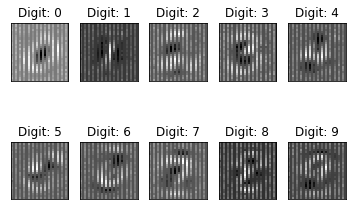

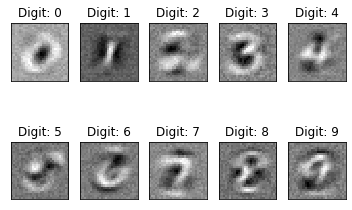

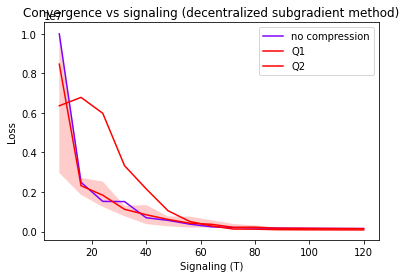

In [70]:
# DSM with Q1
print(datetime.now())
# compute w_k, errs -------------------------
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, decentralized_subgradient_method_agent_, compress = Q1)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['decentralized subgradient method']['Q1'] = (w_k, errs)

# # DSM with Q2
# # compute w_k, errs -------------------------
# w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A, decentralized_subgradient_method_agent_, compress = Q2)

# y_predict = SVM_classify(x_train, w_k)
# print("Training classification error: %.3f" % nmae(y_train, y_predict))
# y_predict = SVM_classify(x_test, w_k)
# print("Test classification error: %.3f" % nmae(y_test, y_predict))

# curves['decentralized subgradient method']['Q2'] = (w_k, errs)

# plot w_k, errs -------------------------
plot_w_ks(curves['decentralized subgradient method']['Q1'][0])
plot_w_ks(curves['decentralized subgradient method']['Q2'][0])
plot_agents_loss('decentralized subgradient method')

2020-04-30 01:51:45.748371
Final loss = 82406.801 and gradient norm = 996.001
2020-04-30 01:52:25.995809
Training classification error: 0.134
Test classification error: 0.128
Final loss = 142946.357 and gradient norm = 934.755
Training classification error: 0.132
Test classification error: 0.126


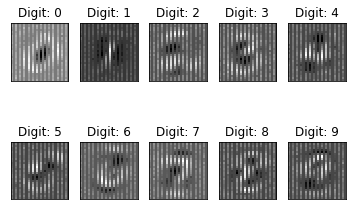

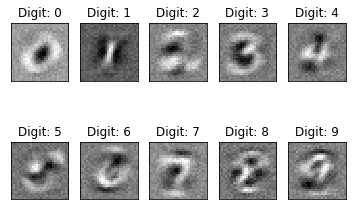

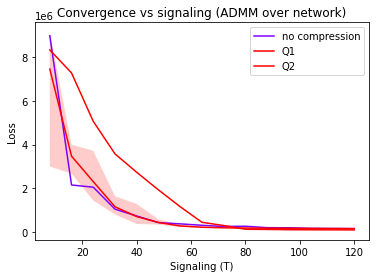

In [71]:
# ADMM with Q1
print(datetime.now())
# compute w_k, errs -------------------------
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_, compress = Q1)
print(datetime.now())

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['ADMM over network']['Q1'] = (w_k, errs)

# ADMM with Q2
# compute w_k, errs -------------------------
w_k, errs = decentralized_method(x_train, y_train, workers_x, workers_y, lambda_, a_k2, max_iter, A_ADMM, admm_over_network_agent_, compress = Q2)

y_predict = SVM_classify(x_train, w_k)
print("Training classification error: %.3f" % nmae(y_train, y_predict))
y_predict = SVM_classify(x_test, w_k)
print("Test classification error: %.3f" % nmae(y_test, y_predict))

curves['ADMM over network']['Q2'] = (w_k, errs)

# plot w_k, errs -------------------------
plot_w_ks(curves['ADMM over network']['Q1'][0])
plot_w_ks(curves['ADMM over network']['Q2'][0])
plot_agents_loss('ADMM over network')